### Set-up and Load Data

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.stats import sigma_clipped_stats, SigmaClip
from scipy.ndimage import zoom
from photutils.background import Background2D, MedianBackground, MMMBackground
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from photutils.psf import GaussianPSF, PSFPhotometry
from astropy.visualization import simple_norm

dataloc = 'ASTR518_observing_data/OJ287/'
figloc = 'ASTR518_project_figures/'

### Step 1: Coordinate Calibration by Astrometry.net

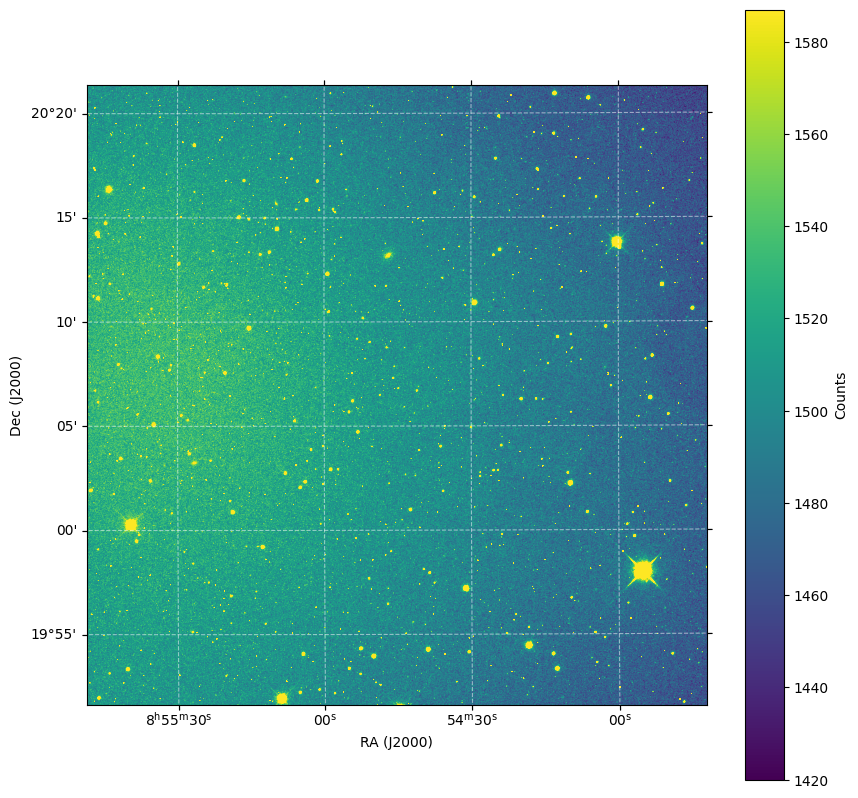

In [3]:
# Step 1: Load the FITS file and extract data and WCS
file_path = dataloc + 'elp0m414-sq31-20241115-0537-e00.fits.fz'  
calibrated_file = dataloc + 'cal_20241115.fits'
hdu = fits.open(file_path)[1]
header = hdu.header
cal_hdu = fits.open(calibrated_file)[0]
data = hdu.data.astype(np.float64)
wcs = WCS(cal_hdu.header)

# Step 2: Normalize the image for better visualization
norm = simple_norm(data, 'linear', percent=95)  # Adjust percent as needed

# Step 3: Plot the image with the WCS grid
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(data, norm=norm, cmap='viridis', origin='lower')
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
ax.coords.grid(color='white', linestyle='--', alpha=0.5)
plt.colorbar(im, ax=ax, orientation='vertical', label='Counts')
plt.show()

### Step 2: Apply a Flat Field (or a Model), Bias, and Dark Subtraction
Use the flat field obtained on the same instrument at the same telescope for each dataset. They have the same FOV but point at different sky regions.
Use 5 Bias and Dark frames for each dataset and take their average to perform subtraction.

In [4]:
bias_loc = 'ASTR518_observing_data/OJ287/bias/'
dark_loc = 'ASTR518_observing_data/OJ287/dark/'

In [5]:
### 11-15 data
bias_frames = ['elp_1.fits.fz', 'elp_2.fits.fz', 'elp_3.fits.fz', 'elp_4.fits.fz', 'elp_5.fits.fz']
dark_frames = ['elp_1115_1.fits.fz', 'elp_1115_2.fits.fz', 'elp_1115_3.fits.fz', 'elp_1115_4.fits.fz', 'elp_1115_5.fits.fz']
### 11-16 data
# bias_frames = ['tfn_1.fits.fz', 'tfn_2.fits.fz', 'tfn_3.fits.fz', 'tfn_4.fits.fz', 'tfn_5.fits.fz']
# dark_frames = ['tfn_1116_1.fits.fz', 'tfn_1116_2.fits.fz', 'tfn_1116_3.fits.fz', 'tfn_1116_4.fits.fz', 'tfn_1116_5.fits.fz']

In [6]:
with fits.open(dark_loc+dark_frames[0]) as hdul:
    t_dark = hdul[1].header['EXPTIME']

In [7]:
with fits.open(dataloc+'flat_1115.fits.fz') as hdul:
    flat_data = hdul[1].data  # Primary data array
    flat_header = hdul[1].header

In [8]:
t_flat = flat_header['EXPTIME']
t_oj = header['EXPTIME']

In [9]:
bias_data = [fits.getdata(bias_loc+bias_frame) for bias_frame in bias_frames]
master_bias = np.mean(bias_data, axis=0)

dark_data = [fits.getdata(dark_loc+dark_frame) for dark_frame in dark_frames]
master_dark = np.mean(dark_data, axis=0) / t_dark * t_oj

In [10]:
bias_subtracted_data = data - master_bias
dark_subtracted_data = bias_subtracted_data - master_dark

In [11]:
# Normalize the flat field and remove bad pixels
mean, _, _ = sigma_clipped_stats(flat_data, sigma=3.0)
flat_mask_data = np.where(flat_data <= 500, mean, flat_data)
flat_norm = flat_mask_data / np.mean(flat_mask_data)

# Rescale the flat field to match the science data resolution (2400x2400)
# Calculate the scaling factor (from flat field shape to science data shape)
scaling_factor_x = data.shape[1] / flat_data.shape[1]
scaling_factor_y = data.shape[0] / flat_data.shape[0]

# Resize the flat field to the shape of the raw science data using zoom (bilinear interpolation)
master_flat = zoom(flat_norm, (scaling_factor_y, scaling_factor_x), order=3)

# Apply to the bias-and-dark-subtracted data
reduced_data = dark_subtracted_data / (master_flat + 1e-6)

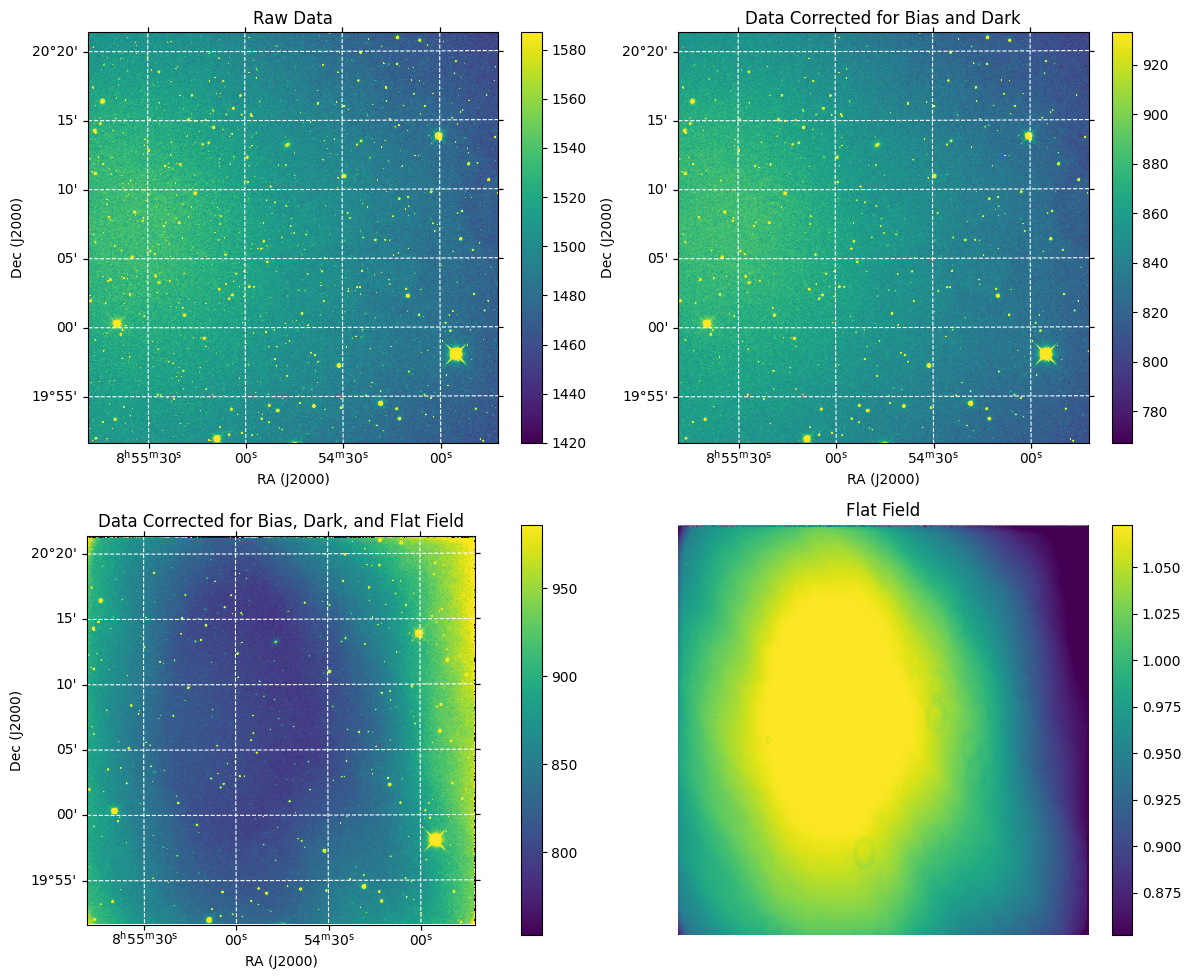

In [12]:
# Create the figure and subplots
fig = plt.figure(figsize=(12, 10))

# First subplot - Raw data with WCS projection
ax0 = fig.add_subplot(2, 2, 1, projection=wcs)  # Apply WCS projection
im0 = ax0.imshow(data, norm=simple_norm(data, 'linear', percent=95), cmap='viridis', origin='lower', aspect='auto')
fig.colorbar(im0, ax=ax0, orientation='vertical', fraction=0.05)  # Add colorbar
ax0.set_title('Raw Data')
ax0.coords.grid(color='white', linestyle='dashed')  # Add grid
ax0.coords[0].set_ticks_visible(True)  # RA axis
ax0.coords[1].set_ticks_visible(True)  # Dec axis
ax0.coords[0].set_ticklabel_visible(True)  # RA labels
ax0.coords[1].set_ticklabel_visible(True)  # Dec labels
ax0.set_xlabel('RA (J2000)')
ax0.set_ylabel('Dec (J2000)')
ax0.set_aspect('equal')

# Second subplot - Dark subtracted data with WCS projection
ax1 = fig.add_subplot(2, 2, 2, projection=wcs)  # Apply WCS projection
im1 = ax1.imshow(dark_subtracted_data, norm=simple_norm(dark_subtracted_data, 'linear', percent=95), cmap='viridis', origin='lower', aspect='auto')
fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.05)  # Add colorbar
ax1.set_title('Data Corrected for Bias and Dark')
ax1.coords.grid(color='white', linestyle='dashed')  # Add grid
ax1.coords[0].set_ticks_visible(True)  # RA axis
ax1.coords[1].set_ticks_visible(True)  # Dec axis
ax1.coords[0].set_ticklabel_visible(True)  # RA labels
ax1.coords[1].set_ticklabel_visible(True)  # Dec labels
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('Dec (J2000)')
ax1.set_aspect('equal')

# Third subplot - Reduced data with WCS projection
ax2 = fig.add_subplot(2, 2, 3, projection=wcs)  # Apply WCS projection
im2 = ax2.imshow(reduced_data, norm=simple_norm(reduced_data, 'linear', percent=95), cmap='viridis', origin='lower', aspect='auto')
fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.05, pad=0.1)  # Add colorbar
ax2.set_title('Data Corrected for Bias, Dark, and Flat Field')
ax2.coords.grid(color='white', linestyle='dashed')  # Add grid
ax2.coords[0].set_ticks_visible(True)  # RA axis
ax2.coords[1].set_ticks_visible(True)  # Dec axis
ax2.coords[0].set_ticklabel_visible(True)  # RA labels
ax2.coords[1].set_ticklabel_visible(True)  # Dec labels
ax2.set_xlabel('RA (J2000)')
ax2.set_ylabel('Dec (J2000)')
ax2.set_aspect('equal')

# Fourth subplot - Flat field (no WCS projection, simple image display)
ax3 = fig.add_subplot(2, 2, 4)  # Standard subplot, no WCS
im3 = ax3.imshow(master_flat, norm=simple_norm(master_flat, 'linear', percent=95), cmap='viridis', origin='lower', aspect='auto')
fig.colorbar(im3, ax=ax3, orientation='vertical', fraction=0.05)  # Add colorbar
ax3.set_title('Flat Field')
ax3.axis('off')  # Turn off axis for this plot
ax3.set_aspect('equal')

# Adjust layout
plt.tight_layout()
plt.savefig(figloc+'reduced_1115_data.png', dpi=300)
plt.show()

### Step 3: Estimate Background Rate
Since there are more bad pixels near the edge, we will perform the following analysis in the central region of the data.

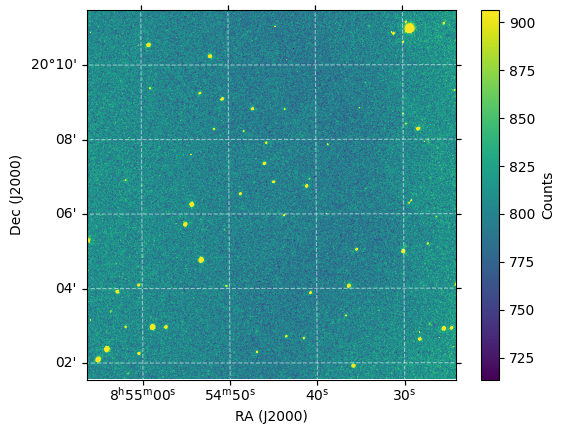

In [13]:
zoomed_wcs = wcs.deepcopy()  # Create a copy of the WCS
zoomed_wcs.wcs.crpix[0] -= 800  # Adjust reference pixel X
zoomed_wcs.wcs.crpix[1] -= 800  # Adjust reference pixel Y
zoomed_data = reduced_data[800:1600, 800:1600]

fig = plt.figure()
ax = fig.add_subplot(111, projection=zoomed_wcs)
im = ax.imshow(zoomed_data, norm=simple_norm(zoomed_data, 'linear', percent=99), cmap='viridis', origin='lower')
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
ax.coords.grid(color='white', linestyle='--', alpha=0.5)
plt.colorbar(im, ax=ax, orientation='vertical', label='Counts')
plt.show()

#### 3.1 Simple Estimation

In [14]:
# Estimate the background using a 2D background model
# Define box size for large-scale variations
box_size = 10  # Adjust based on the field
bkg_estimator = MMMBackground(sigma_clip=SigmaClip(sigma=3.0, maxiters=10))
bkg = Background2D(zoomed_data, box_size, bkg_estimator=bkg_estimator)

# Use sigma-clipped statistics to estimate background noise
mean, median, std = sigma_clipped_stats(bkg.background, sigma=3.0)

# Print out background and noise estimate
print(f"Estimated Background: {median/t_oj}/s/pixel")
print(f"Background Standard Deviation: {std}")

Estimated Background: 8.010987075432336/s/pixel
Background Standard Deviation: 6.5938915392075765


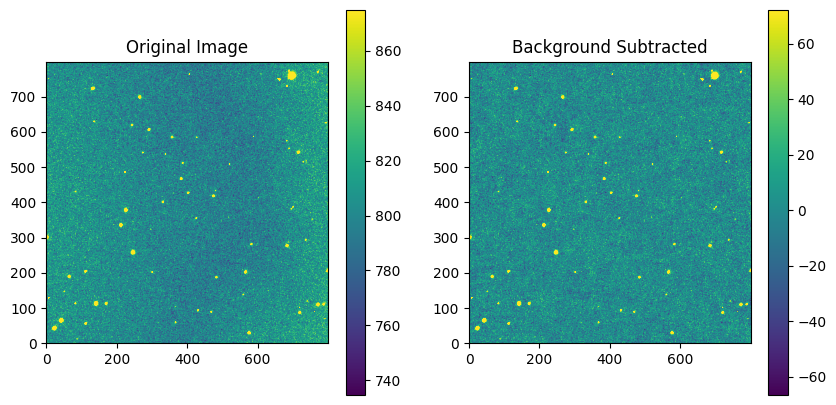

In [15]:
background_subtracted_data = zoomed_data - bkg.background

# Plot the background and the background-subtracted image
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(121)
plt.imshow(zoomed_data, norm=simple_norm(zoomed_data, 'linear', percent=95), origin='lower', cmap='viridis')
plt.title('Original Image')
plt.colorbar()

# Background-subtracted image
plt.subplot(122)
plt.imshow(background_subtracted_data, norm=simple_norm(background_subtracted_data, 'linear', percent=95), origin='lower', cmap='viridis')
plt.title('Background Subtracted')
plt.colorbar()

plt.show()

#### 3.2 Complicated Estimaion

In [43]:
### aperture size
### 11-15 has seeing limit of 41.38", 11-16 has seeing limit of 3.99"
seeing = 41.38
plate_scale = 2.42
aperture_size = 2 * seeing / plate_scale

In [32]:
# Step 1: Load the FITS file and extract data and WCS
# file_path = dataloc + 'elp0m414-sq31-20241115-0537-e00.fits.fz'  
# calibrated_file = dataloc + 'cal_20241115.fits'
# hdu = fits.open(file_path)[1]
# cal_hdu = fits.open(calibrated_file)[0]
# data = hdu.data
# wcs = WCS(cal_hdu.header)

# Step 2: Estimate the background using a 2D background model
# Define box size for large-scale variations
# box_size = 24  # Adjust based on the field
# bkg_estimator = MMMBackground()  # Replacing MedianBackground
# bkg = Background2D(data, box_size, bkg_estimator=bkg_estimator)

# # Step 3: Subtract the background
# background_subtracted_data = data - bkg.background

In [33]:
# Step 4: Use DAOStarFinder to detect sources
mean, median, std = sigma_clipped_stats(zoomed_data, sigma=3.0)
threshold = 5 * std  # Adjust depending on source brightness
star_finder = DAOStarFinder(fwhm=5.0, threshold=threshold)
sources = star_finder(zoomed_data)
xcentroid = np.array(sources['xcentroid'])
ycentroid = np.array(sources['ycentroid'])
source_pos = np.vstack((xcentroid, ycentroid)).T

# Step 5: Create a PSF model
# We use a Gaussian model for simplicity
psf_model = GaussianPSF(x_fwhm=20, y_fwhm=20)  # Adjust sigma based on seeing

# Step 6: Define the photometry configuration
aperture_radius = aperture_size
aperture = CircularAperture(source_pos, r=aperture_radius)

# Step 7: Perform iterative PSF photometry to get fluxes and background estimate
psf_photometry = PSFPhotometry(
    finder=star_finder,
    psf_model=psf_model,
    aperture_radius=aperture_radius,
    fit_shape=(11, 11)
)

In [34]:
# Step 8: Extract photometry results
results = psf_photometry(zoomed_data)
fluxes = results['flux_fit']
flux_errors = results['flux_err']

# Step 9: Estimate the background in each aperture
# The background is calculated iteratively by PSF subtraction
# You can also directly calculate the mean background using the residuals from PSF photometry
psf_model = psf_photometry.make_model_image(zoomed_data.shape)
residuals = zoomed_data - psf_model
mean_residual, _, _ = sigma_clipped_stats(residuals, sigma=3.0)
background_rate = mean_residual / t_oj  # Background rate estimate

# Print the results
print(f"Background Rate Estimate: {background_rate:.3f}/s/pixel")
print(f"Number of sources detected: {len(sources)}")

Background Rate Estimate: 7.979/s/pixel
Number of sources detected: 61


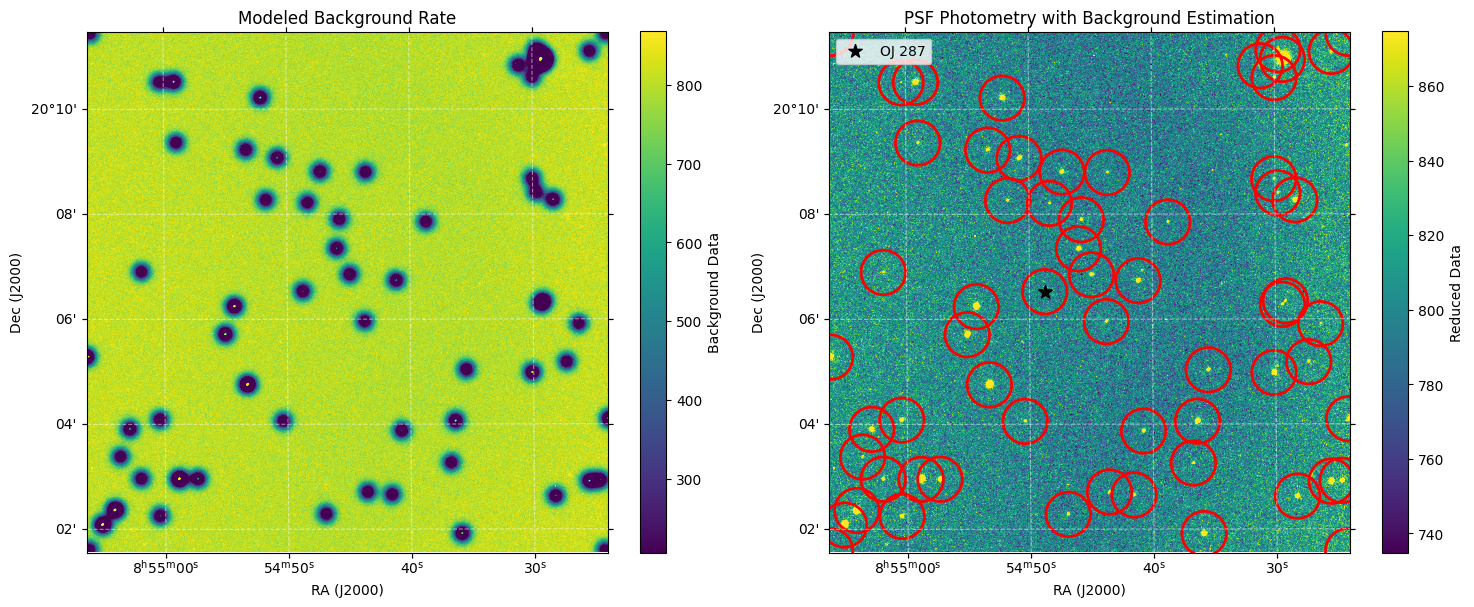

In [35]:
# Step 10: Plot the data with the PSF model
# Create the figure and subplots (2 subplots, 1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': zoomed_wcs})

# First subplot: PSF Photometry with Background Estimation
ax1 = axs[1]  # Right subplot
ax1.scatter(331, 400, s=100, c='k', marker='*', label='OJ 287')  # Plot OJ 287
im1 = ax1.imshow(zoomed_data, norm=simple_norm(zoomed_data, 'linear', percent=95), 
                 origin='lower', cmap='viridis')  # Zoomed data
aperture.plot(color='red', lw=2, ax=ax1)  # Plot apertures on detected sources
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('Dec (J2000)')
ax1.legend(loc=2)
ax1.coords.grid(color='white', linestyle='--', alpha=0.5)  # Grid for WCS
fig.colorbar(im1, ax=ax1, orientation='vertical', label=r'Reduced Data')  # Colorbar
ax1.set_title('PSF Photometry with Background Estimation')

# Second subplot
ax2 = axs[0]  # Left subplot
im2 = ax2.imshow(residuals, norm=simple_norm(residuals, 'linear', percent=95), 
                 origin='lower', cmap='viridis')  # Same data, different colormap

ax2.set_xlabel('RA (J2000)')
ax2.set_ylabel('Dec (J2000)')
ax2.coords.grid(color='white', linestyle='--', alpha=0.5)  # Grid for WCS
fig.colorbar(im2, ax=ax2, orientation='vertical', label='Background Data')  # Colorbar
ax2.set_title('Modeled Background Rate')

# Adjust layout
plt.tight_layout()
plt.savefig(figloc+'background_sub_1115.png', dpi=300)
plt.show()

### Step 4: Measure the Count Rate with Aperture or PSF Photometry

#### 4.1 Aperture Photometry

Totla pixels: 3681
Measured Count Rate: 0.43 counts/s/pixel


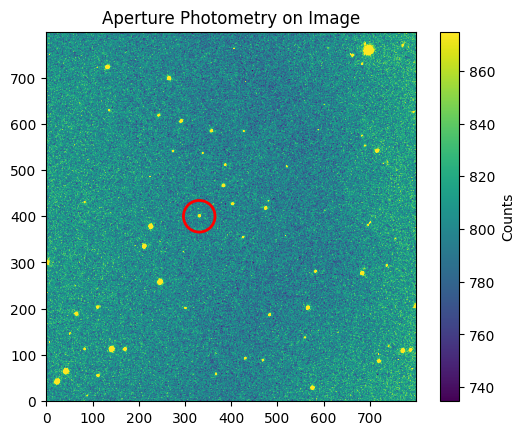

In [36]:
# Function to perform aperture photometry
def aperture_photometry(image, center, aperture_radius, background, background_radius, exposure_time=t_oj):
    """
    Perform aperture photometry on a given image.

    Parameters:
    image (2D array): The 2D array representing the image (e.g., fits file).
    center (tuple): (x, y) coordinates of the source (in pixel units).
    aperture_radius (float): The radius of the aperture in pixels.
    background (2D array): The modelled background flux.
    background_radius (float): The radius of the annulus used for background measurement.

    Returns:
    count_rate (float): The measured count rate.
    """
    # Create a circular mask for the aperture
    y, x = np.indices(image.shape)
    aperture_mask = (x - center[0])**2 + (y - center[1])**2 <= aperture_radius**2
    
    # Create an annular mask for the background region
    background_mask = ((x - center[0])**2 + (y - center[1])**2 >= aperture_radius**2) & \
                       ((x - center[0])**2 + (y - center[1])**2 <= (aperture_radius + background_radius)**2)
    
    # Measure the total counts in the aperture
    aperture_counts = np.sum(image[aperture_mask])
    
    # Measure the background counts (scaled by the area of the aperture)
    background_counts = np.sum(background[background_mask]) / background_mask.sum() * aperture_mask.sum()
    
    # Subtract background from aperture counts
    net_counts = aperture_counts - background_counts
    
    # Calculate count rate
    count_rate = net_counts / exposure_time / aperture_mask.sum()
    
    return count_rate, aperture_mask.sum()


# Example: Read an image and perform aperture photometry
def main():
    # Load the FITS image (replace with your own file)
    image = zoomed_data  # Simulated image with Poisson noise

    # Set parameters
    center = (331, 400)  # Center of the source (in pixels)
    aperture_radius = aperture_size  # Aperture radius (in pixels)
    background = residuals  # Background rate (e.g., counts per pixel per second)
    background_radius = 2*aperture_size  # Radius of the annulus (in pixels)

    # Perform aperture photometry
    count_rate, aperture_pixels = aperture_photometry(image, center, aperture_radius, background, background_radius)

    print(f"Totla pixels: {aperture_pixels:.0f}")
    print(f"Measured Count Rate: {count_rate:.2f} counts/s/pixel")

    # Plot the image with the aperture
    plt.imshow(image, norm=simple_norm(image, 'linear', percent=95), cmap='viridis', origin='lower')
    circle = plt.Circle(center, aperture_radius, color='r', fill=False, lw=2)
    plt.gca().add_artist(circle)
    plt.title('Aperture Photometry on Image')
    plt.colorbar(label='Counts')
    plt.show()

    return aperture_pixels

if __name__ == '__main__':
    aperture_pixels = main()

#### 4.2 PSF Photometry

Fitted Parameters: [1.00055253e+03 5.00520594e+01 5.00671837e+01 8.47946389e+00
 8.47946459e+00 2.00760831e+07 8.12139948e-01]
Measured Flux: 4520.19 counts/s
Number of Pixels in the Fitted PSF: 2033


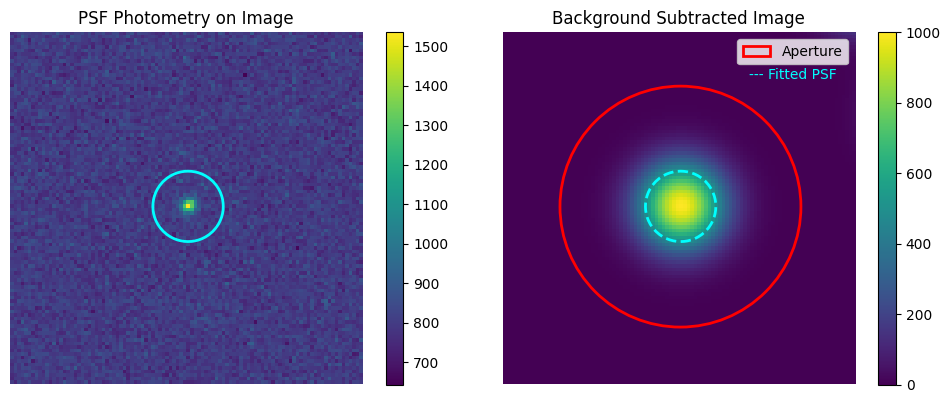

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits

# Define a 2D Gaussian function
def gaussian_2d(x, y, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    """
    2D Gaussian function to fit to the data.
    
    Parameters:
    x, y: 2D meshgrid coordinates
    amplitude: Amplitude of the Gaussian
    x0, y0: Coordinates of the peak (center)
    sigma_x, sigma_y: Standard deviations (width) in x and y directions
    theta: Rotation angle of the ellipse (radians)
    offset: Background offset
    
    Returns:
    Gaussian evaluated at each (x, y) point
    """
    # Rotation matrix to account for the angle theta
    a = np.cos(theta)**2 / (2 * sigma_x**2) + np.sin(theta)**2 / (2 * sigma_y**2)
    b = -np.sin(2 * theta) / (4 * sigma_x**2) + np.sin(2 * theta) / (4 * sigma_y**2)
    c = np.sin(theta)**2 / (2 * sigma_x**2) + np.cos(theta)**2 / (2 * sigma_y**2)
    
    # Apply the Gaussian formula
    return amplitude * np.exp(
        - (a * (x - x0)**2 + 2 * b * (x - x0) * (y - y0) + c * (y - y0)**2)
    ) + offset

# Function to perform PSF photometry (fit the Gaussian model)
def psf_photometry(image, center, initial_guess, background):
    """
    Perform PSF photometry by fitting a 2D Gaussian to the image.

    Parameters:
    image (2D array): The 2D array representing the image (e.g., fits file).
    center (tuple): (x, y) coordinates of the source (in pixel units).
    initial_guess (tuple): Initial guess for the Gaussian fit parameters (amplitude, xo, yo, sigma_x, sigma_y, theta, offset).
    background (2D array): The modelled background flux.

    Returns:
    fitted_params (tuple): The fitted parameters of the Gaussian (amplitude, xo, yo, sigma_x, sigma_y, theta, offset).
    flux (float): The total flux of the source.
    """
    # Create a meshgrid of coordinates for fitting
    y, x = np.indices(image.shape)
    
    # Subtract background
    image_background_subtracted = image - background

    # Fit the Gaussian model to the image data
    popt, _ = curve_fit(
        lambda coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset: 
            gaussian_2d(coords[0], coords[1], amplitude, xo, yo, sigma_x, sigma_y, theta, offset).flatten(),
        (x, y), image_background_subtracted.flatten(),
        p0=initial_guess
    )

    # Extract the fitted parameters
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt

     # Approximate the number of pixels in the PSF (using 3 sigma rule for 99.7% of the flux)
    num_pixels = np.pi * (3 * sigma_x) * (3 * sigma_y)

    # Calculate the flux
    flux = amplitude * 2 * np.pi * sigma_x * sigma_y / t_oj

    return popt, flux, num_pixels


# Example: Read an image and perform PSF photometry
def main():
    # Load the FITS image (replace with your own file)
    # Here we simulate an example image with some artificial data
    # Load the FITS image (replace with your own file)
    image = zoomed_data  # Replace with your actual file path

    # Coordinates of OJ 287 (example coordinates, replace with actual)
    center = (400, 331)  # Example coordinates (replace with the actual location of OJ 287)
    
    # Define the size of the region to zoom into (this will extract a 50x50 pixel region around OJ 287)
    region_size = 100  # Size of the sub-image (in pixels)
    x_min = center[0] - region_size // 2
    x_max = center[0] + region_size // 2
    y_min = center[1] - region_size // 2
    y_max = center[1] + region_size // 2

    # Extract the sub-image around OJ 287
    sub_image = image[x_min:x_max, y_min:y_max]
    background = residuals[x_min:x_max, y_min:y_max]  # Background rate (e.g., counts per pixel per second)
    initial_guess = (100, region_size // 2, region_size // 2, 3, 3, 0, np.median(background))  # Initial guess for Gaussian

    # Perform PSF photometry
    fitted_params, flux, num_pixels = psf_photometry(sub_image, center, initial_guess, background)
    
    print(f"Fitted Parameters: {fitted_params}")
    print(f"Measured Flux: {flux:.2f} counts/s")
    print(f"Number of Pixels in the Fitted PSF: {num_pixels:.0f}")

    # Plot the image with the Gaussian fit overlay
    y, x = np.indices(sub_image.shape)
    fitted_image = gaussian_2d(x, y, *fitted_params).reshape(sub_image.shape)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axs[0].imshow(sub_image, cmap='viridis', origin='lower')
    axs[0].axis('off')  # Hide axes for better presentation
    fig.colorbar(im0, ax=axs[0], orientation='vertical')  # Add colorbar
    axs[0].contour(fitted_image, colors='cyan', levels=[fitted_image.max()/2], linewidths=2)  # Contour of the fitted PSF
    axs[0].set_title('PSF Photometry on Image')

    im1 = axs[1].imshow(sub_image - background, cmap='viridis', origin='lower')
    axs[1].axis('off')  # Hide axes for better presentation
    fig.colorbar(im1, ax=axs[1], orientation='vertical')  # Add colorbar
    axs[1].contour(fitted_image, colors='cyan', levels=[fitted_image.max()/2], linewidths=2, linestyles='dashed')  # Contour of the fitted PSF
    circle0 = Circle((region_size // 2, region_size // 2), aperture_size, color='red', fill=False, linewidth=2, label='Aperture')
    axs[1].add_patch(circle0)
    axs[1].set_title('Background Subtracted Image')
    axs[1].legend(loc=1)
    contour_label = "--- Fitted PSF"
    axs[1].text(
        0.70, 0.90, contour_label, color='cyan', fontsize=10, transform=axs[1].transAxes, verticalalignment='top'
    )
    
    plt.tight_layout()
    plt.savefig(figloc+'photometry_1115.png', dpi=300)
    plt.show()

    return flux, num_pixels

if __name__ == '__main__':
    flux, num_pixels = main()

### Step 5: Distribution of Counts per Pixel within the Aperture

In [47]:
### data and background around OJ 287
center = (400, 331)
    
# Define the size of the region to zoom into (this will extract a 50x50 pixel region around OJ 287)
region_size = 100  # Size of the sub-image (in pixels)
x_min = center[0] - region_size // 2
x_max = center[0] + region_size // 2
y_min = center[1] - region_size // 2
y_max = center[1] + region_size // 2

oj_data = zoomed_data[x_min:x_max, y_min:y_max]
oj_bkg = residuals[x_min:x_max, y_min:y_max]

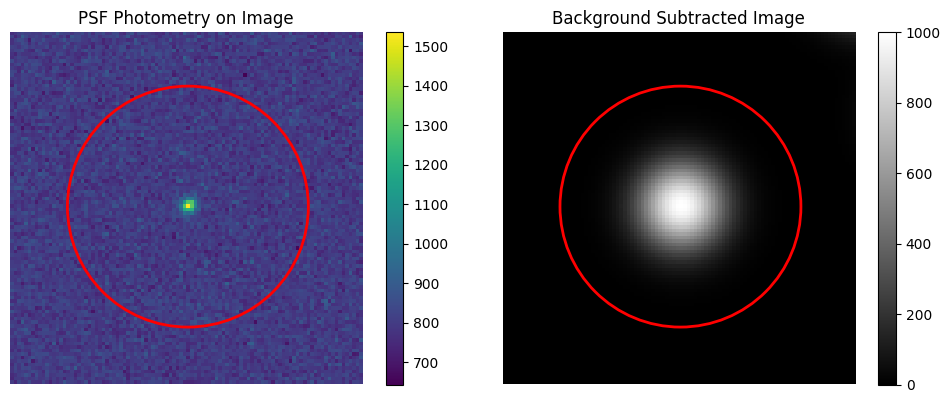

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
circle0 = Circle((region_size // 2, region_size // 2), aperture_size, color='red', fill=False, linewidth=2)
circle1 = Circle((region_size // 2, region_size // 2), aperture_size, color='red', fill=False, linewidth=2)

im0 = axs[0].imshow(oj_data, cmap='viridis', origin='lower')
axs[0].axis('off')  # Hide axes for better presentation
fig.colorbar(im0, ax=axs[0], orientation='vertical')  # Add colorbar
axs[0].add_patch(circle0)
axs[0].set_title('PSF Photometry on Image')

im1 = axs[1].imshow(oj_data - oj_bkg, cmap='grey', origin='lower')
axs[1].axis('off')  # Hide axes for better presentation
fig.colorbar(im1, ax=axs[1], orientation='vertical')  # Add colorbar
axs[1].add_patch(circle1)
axs[1].set_title('Background Subtracted Image')
plt.tight_layout()
plt.show()

The distribution of counts within the aperture is very similar to a Gaussian profile with central brightness and surroundings with descent brightness. We don't see an Airy disk in this case and this might be caused by following reasons: 
1. The system is undeersampled. The central wavelength of SDSS-R filter is 623nm, D of the telescope is 0.4m. So the diffraction limit is about 0.392". But the plate scale is given as 2.42"/binned pixel (0.74"/pixel). Thus the detector cannot fully resolve the diffraction pattern.
2. The seeing condition is not good for this observation, ~ 4".
3. The background subtraction can be refined. Currently the background is modelled by PSF Photometry after removing all sources (based on some thresholds).
4. The pixels are not saturated based on the FITS file associated with the data, so this is not the reason.

### Step 6: Breakdown of Contributing Uncertainties

1. Bias and Dark Frame Subtraction:
Bias Frame Uncertainty: The bias frame contains the readout noise and any fixed pattern noise. The uncertainty here comes from variations in the bias levels, which can differ slightly across frames. This is typically quantified by the standard deviation of the bias frame.
Dark Frame Uncertainty: Dark frames account for thermal noise. Uncertainty comes from variations in dark current across the frame and from any residual structure after subtracting the dark frame.

2. Flat Fielding:
Flat Field Uncertainty: The flat field accounts for pixel-to-pixel sensitivity variations and any vignetting. Uncertainty arises from the precision of the flat field calibration, and its quality depends on the number of flat frames taken and the stability of the instrument.
Flat Field Variations: If the flat field is not accurately captured (e.g., from a varying illumination source), the uncertainty can propagate into the final data reduction.

3. Background Subtraction (PSF Photometry):
PSF Model Fitting Uncertainty: The accuracy of the Point Spread Function (PSF) fitting and SAO star finder can introduce uncertainty, especially if the PSF is not well-matched to the observed object or if there is a poor signal-to-noise ratio. The model fitting typically includes errors from the shape and scale of the Gaussian used to fit the data.
Background Estimation Uncertainty: The background subtraction introduces uncertainty based on how well the background level is estimated in the frame. This can be impacted by nearby sources, variations in the sky background, or residuals in the subtraction process.

4. Count Rate Estimation (Gaussian Fitting of PSF):
Gaussian Fitting Uncertainty: The uncertainty in fitting a 2D Gaussian distribution arises from several factors, such as the precision of the center, width, and amplitude parameters. If the object is faint or has a low signal-to-noise ratio, fitting errors increase. Additionally, the choice of initial parameters and the optimization method can affect the result.
Photometric Uncertainty: The uncertainty in the photometric measurement of the count rate depends on the precision of the fitting process, including the noise in the background and the inherent noise in the image (photon noise, readout noise, etc.).

5. Instrumental and Observational Uncertainties:
Photon Noise: The inherent statistical uncertainty in the number of detected photons, especially for faint objects, can significantly contribute to the uncertainty in the count rate.
Temporal Variability: For variable objects like OJ 287, the uncertainty in the measurement can also depend on the time between observations and any short-term variability in the object that was not accounted for.
Filter and Bandpass Calibration: If there is any uncertainty in the calibration of the photometric filter or the bandpass characteristics, this can propagate into the observed count rate.
Telescope Systematics: Any issues with the instrument, such as misalignment or imperfect optical components, can introduce systematic errors in the measurements.

### Step 7: SNR Calculation

In [49]:
def calc_snr(s0, ss, npix, sd=0.01, R=3.1, t=t_oj, g=0.77, q=0.7):
    signal = s0*q*t*g
    noise = np.sqrt(s0*q*t*g + ss*npix*q*t*g + sd*npix*t*g + R**2 * g**2 * npix**2)
    return signal/noise

In [41]:
display(calc_snr(flux, background_rate, aperture_pixels))

27.494632539436378